# Orthogonal RNN

Train Orthogonal RNN for MNIST classification based on [this Paper](https://arxiv.org/pdf/1901.08428.pdf)

NOTE: this example is still under development. 

## Problem Description

For each element in the input sequence, each layer computes the following function:
$$h_t=\tanh(W_{ih}x_t+b_{ih}+W_{hh}h_{t-1}+b_hh)$$

where $h_{t}$ is the hidden state at time $t$, and $h_{t-1}$ is the hidden state of the previous layer at time $t-1$ or the initial hidden state at time $o$. 

For each layer, we have the orthogonal constraint:
$$ W_{hh}^T W_{hh} = I $$

## Modules Importing
Import all necessary modules and add PyGRANSO src folder to system path. 

In [1]:
import time
import torch
import sys
## Adding PyGRANSO directories. Should be modified by user
sys.path.append('.')
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct 
from pygranso.private.getNvar import getNvarTorch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from pygranso.private.getObjGrad import getObjGradDL

In [2]:
import torch

# fix the random seed
torch.manual_seed(55272025)

w = 8

## Data Initialization 
Specify torch device, neural network architecture, and generate data.

NOTE: please specify path for downloading data.

Use GPU for this problem. If no cuda device available, please set *device = torch.device('cpu')*

In [3]:
device = torch.device('cpu')

sequence_length = 28
input_size = 28
hidden_size = 30
num_layers = 1
num_classes = 10
batch_size = 1024


double_precision = torch.double

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        x = torch.reshape(x,(batch_size,sequence_length,input_size))
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=device, dtype=double_precision)
        out, hidden = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
    
torch.manual_seed(0)

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device=device, dtype=double_precision)
model.train()

train_data = datasets.MNIST(
    root = './examples/data/mnist',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
) 
test_data = datasets.MNIST(
    root = './examples/data/mnist',
    train = False,                         
    transform = ToTensor(), 
    download = True,            
) 

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                        batch_size=batch_size, 
                                        shuffle=True, 
                                        num_workers=1),
    'test' : torch.utils.data.DataLoader(test_data, 
                                        batch_size=batch_size, 
                                        shuffle=True, 
                                        num_workers=1),
}

inputs, labels = next(iter(loaders['train']))
inputs, labels = inputs.reshape(-1, sequence_length, input_size).to(device=device, dtype=double_precision), labels.to(device=device)

test_inputs, test_labels = next(iter(loaders['test']))
test_inputs, test_labels = test_inputs.reshape(-1, sequence_length, input_size).to(device=device, dtype=double_precision), test_labels.to(device=device)

## Function Set-Up

Encode the optimization variables, and objective and constraint functions.

Note: please strictly follow the format of comb_fn, which will be used in the PyGRANSO main algortihm.

In [4]:
def user_fn(model,inputs,labels):
    # objective function    
    logits = model(inputs)
    criterion = nn.CrossEntropyLoss()
    f = criterion(logits, labels)

    A = list(model.parameters())[1]

    # inequality constraint
    ci = None

    # equality constraint 
    # special orthogonal group
    
    ce = pygransoStruct()

    c1_vec = (A.T @ A 
              - torch.eye(hidden_size)
              .to(device=device, dtype=double_precision)
             ).reshape(1,-1)
    
    ce.c1 = torch.linalg.vector_norm(c1_vec,2) # l2 folding to reduce the total number of constraints
    # ce.c2 = torch.det(A) - 1

    # ce = None

    return [f,ci,ce]

comb_fn = lambda model : user_fn(model,inputs,labels)

## User Options
Specify user-defined options for PyGRANSO 

In [5]:
opts = pygransoStruct()
opts.torch_device = device
nvar = getNvarTorch(model.parameters())
opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
opts.opt_tol = 1e-3
opts.viol_eq_tol = 1e-4
# opts.maxit = 150
# opts.fvalquit = 1e-6
opts.print_level = 1
opts.print_frequency = 50
# opts.print_ascii = True
# opts.limited_mem_size = 100
opts.double_precision = True

opts.mu0 = 1

## Initial Test 
Check initial accuracy of the RNN model

In [6]:
logits = model(inputs)
_, predicted = torch.max(logits.data, 1)
correct = (predicted == labels).sum().item()
print("Initial acc = {:.2f}%".format((100 * correct/len(inputs))))  

Initial acc = 8.79%


# Exact Penalty with PyGRANSO

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.nn.functional import one_hot

In [8]:
train_acc = []
test_acc = []

In [9]:
val_dataloader = loaders['test']

In [10]:
def f(model, inputs, labels):
    logits = model(inputs)
    loss_fn = nn.CrossEntropyLoss()
    return loss_fn(logits, labels)

def penalty(model):
    A = list(model.parameters())[1]
    
    # print(A)
    
    return torch.norm(A.T @ A - torch.eye(hidden_size), p=1)

def l2_penalty(model):
    A = list(model.parameters())[1]
    
    # print(A)
    
    return torch.norm(A.T @ A - torch.eye(hidden_size))

def phi1(model, mu):
    return f(model, inputs, labels) + mu * penalty(model)

In [11]:
def train_loop(model, mu, optimizer):
    model.train()
    
    loss = phi1(model, mu)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

def val_loop(dataloader, model):
    model.eval()
    # size = len(dataloader.dataset)
    size = batch_size
    correct = 0

    with torch.no_grad():
        logits = model(inputs)
        _, predicted = torch.max(logits.data, 1)
        train_acc.append((predicted == labels).sum().item() / size)
        
        logits = model(test_inputs)
        _, predicted = torch.max(logits.data, 1)
        c = (predicted == test_labels).sum().item()
        test_acc.append(c / size)
        correct += c
    
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}% \n")
    return 100*correct

### 1000 inner epochs

In [12]:
def exact_penalty_with_pygranso(mu_rho, mu_eps):
    mu = torch.tensor([1.], dtype=double_precision)

    for iteration in range(1000):
        print("Iter", iteration)
        
        # PyGRANSO
        def comb_fn(model):
            # objective function
            phi1_x_mu = phi1(model, mu)
        
            # inequality constraint, matrix form
            ci = None
        
            # equality constraint 
            ce = None
        
            return [phi1_x_mu,ci,ce]
        
        opts = pygransoStruct()
        # option for switching QP solver. We only have osqp as the only qp solver in current version. Default is osqp
        # opts.QPsolver = 'osqp'
        
        # set an intial point
        # All the user-provided data (vector/matrix/tensor) must be in torch tensor format. 
        # As PyTorch tensor is single precision by default, one must explicitly set `dtype=torch.double`.
        # Also, please make sure the device of provided torch tensor is the same as opts.torch_device.
        nvar = getNvarTorch(model.parameters())
        opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
        opts.torch_device = device
        opts.opt_tol = 1e-5
        opts.viol_eq_tol = 1e-5
        opts.print_level = 1
        opts.print_frequency = 50
        
        # opts.maxit = 1000 yields 80% acc but seems far from reaching stationarity
        #  900 ║  - │   -   ║  0.76603445858 ║   -  │   -  ║ QN │     6 │ 0.031250 ║     1 │ 0.246480   ║ 
        #  950 ║  - │   -   ║  0.70312720877 ║   -  │   -  ║ QN │     6 │ 0.031250 ║     1 │ 0.471985   ║ 
        # ═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
        #      ║ Penalty Fn ║                ║  Violation  ║ <--- Line Search ---> ║ <- Stationarity -> ║ 
        # Iter ║ Mu │ Value ║    Objective   ║ Ineq │  Eq  ║ SD │ Evals │     t    ║ Grads │    Value   ║ 
        # ═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
        # 1000 ║  - │   -   ║  0.62800096715 ║   -  │   -  ║ QN │     5 │ 0.062500 ║     1 │ 0.430504   ║ 
        opts.maxit = 1000  # Inner epochs
        opts.print_level = iteration <= 2
        
        start = time.time()
        soln = pygranso(var_spec = model,combined_fn = comb_fn, user_opts = opts)
        end = time.time()
        print("Total Wall Time: {}s".format(end - start))
        torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
        
        # Exact penalty update
        
        h = penalty(model)
        print("Objective:", f(model, inputs, labels))
        print("Penalty parameter:", mu)
        print("Penalty:", h)
        if h < 1e-3:  # if h(xk ) ≤ τ
            break

        # Choose new penalty parameter µk+1 > µk ;
        if mu * h > mu_eps:
            mu *= mu_rho

        # Choose new starting point (stay as optimal x1, x2)

        print()

In [13]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device=device, dtype=double_precision)
exact_penalty_with_pygranso(mu_rho=1.1, mu_eps=1e-5)

Iter 0


╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specificat

### Train Acc

In [14]:
model.eval()

logits = model(inputs)
_, predicted = torch.max(logits.data, 1)
correct = (predicted == labels).sum().item()
print("Final acc = {:.2f}%".format((100 * correct/len(inputs))))  

Final acc = 54.39%


### Test Acc

In [15]:
val_loop(val_dataloader, model)

Error: 
 Accuracy: 52.6% 



52.63671875

### Feasibility

In [16]:
penalty(model)

tensor(0.0001, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

In [17]:
l2_penalty(model)

tensor(1.2289e-05, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

### Graph

In [18]:
import numpy as np
import matplotlib.pyplot as plt

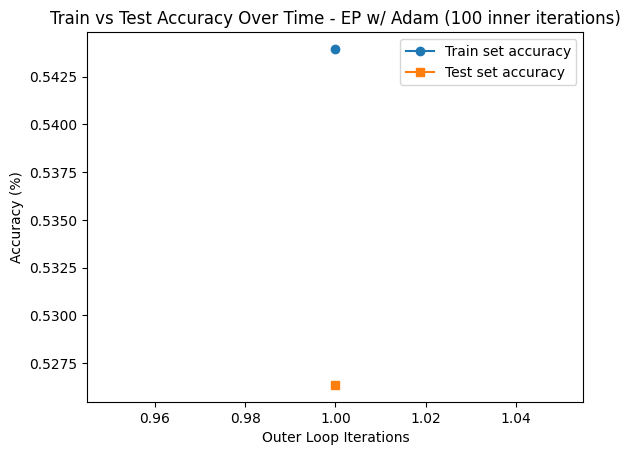

In [19]:
# Plot results
x = np.arange(1, len(train_acc)+1)

plt.plot(x, train_acc, label='Train set accuracy', marker='o')
plt.plot(x, test_acc, label='Test set accuracy', marker='s')

plt.xlabel('Outer Loop Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy Over Time - EP w/ Adam (100 inner iterations)'.format(batch_size))

plt.legend()

plt.show()

In [20]:
train_acc_1000 = train_acc.copy()
test_acc_1000 = test_acc.copy()

### 3000 inner epochs

In [21]:
train_acc = []
test_acc = []

In [22]:
def exact_penalty_with_pygranso(mu_rho, mu_eps):
    mu = torch.tensor([1.], dtype=double_precision)

    for iteration in range(1000):
        print("Iter", iteration)
        
        # PyGRANSO
        def comb_fn(model):
            # objective function
            phi1_x_mu = phi1(model, mu)
        
            # inequality constraint, matrix form
            ci = None
        
            # equality constraint 
            ce = None
        
            return [phi1_x_mu,ci,ce]
        
        opts = pygransoStruct()
        # option for switching QP solver. We only have osqp as the only qp solver in current version. Default is osqp
        # opts.QPsolver = 'osqp'
        
        # set an intial point
        # All the user-provided data (vector/matrix/tensor) must be in torch tensor format. 
        # As PyTorch tensor is single precision by default, one must explicitly set `dtype=torch.double`.
        # Also, please make sure the device of provided torch tensor is the same as opts.torch_device.
        nvar = getNvarTorch(model.parameters())
        opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
        opts.torch_device = device
        opts.opt_tol = 1e-5
        opts.viol_eq_tol = 1e-5
        opts.print_level = 1
        opts.print_frequency = 50
        
        # opts.maxit = 1000 yields 80% acc but seems far from reaching stationarity
        #  900 ║  - │   -   ║  0.76603445858 ║   -  │   -  ║ QN │     6 │ 0.031250 ║     1 │ 0.246480   ║ 
        #  950 ║  - │   -   ║  0.70312720877 ║   -  │   -  ║ QN │     6 │ 0.031250 ║     1 │ 0.471985   ║ 
        # ═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
        #      ║ Penalty Fn ║                ║  Violation  ║ <--- Line Search ---> ║ <- Stationarity -> ║ 
        # Iter ║ Mu │ Value ║    Objective   ║ Ineq │  Eq  ║ SD │ Evals │     t    ║ Grads │    Value   ║ 
        # ═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
        # 1000 ║  - │   -   ║  0.62800096715 ║   -  │   -  ║ QN │     5 │ 0.062500 ║     1 │ 0.430504   ║ 
        opts.maxit = 3000  # Inner epochs
        opts.print_level = iteration <= 2
        
        start = time.time()
        soln = pygranso(var_spec = model,combined_fn = comb_fn, user_opts = opts)
        end = time.time()
        print("Total Wall Time: {}s".format(end - start))
        torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
        
        # Exact penalty update
        
        h = penalty(model)
        print("Objective:", f(model, inputs, labels))
        print("Penalty parameter:", mu)
        print("Penalty:", h)
        if h < 1e-3:  # if h(xk ) ≤ τ
            break

        # Choose new penalty parameter µk+1 > µk ;
        if mu * h > mu_eps:
            mu *= mu_rho

        # Choose new starting point (stay as optimal x1, x2)

        print()

In [23]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device=device, dtype=double_precision)
exact_penalty_with_pygranso(mu_rho=1.1, mu_eps=1e-5)

Iter 0


╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specificat

### Train Acc

In [24]:
model.eval()

logits = model(inputs)
_, predicted = torch.max(logits.data, 1)
correct = (predicted == labels).sum().item()
print("Final acc = {:.2f}%".format((100 * correct/len(inputs))))  

Final acc = 97.75%


### Test Acc

In [25]:
val_loop(val_dataloader, model)

Error: 
 Accuracy: 67.6% 



67.578125

### Feasibility

In [27]:
penalty(model)

tensor(1.1091e-05, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

In [29]:
l2_penalty(model)

tensor(9.8434e-07, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)